# 

In [ ]:
# Реализовать генератор пользовательских данных для решения задачи подсчета количества клеток крови на изображениях клеток крови.
# Изучите набор данных, располагающийся в архиве blood_cells.
# Выполните "нарезку" изображений. Сохраните в отдельные папки изображения фона и изображения клеток крови.
# Реализуйте генератор данных: снимков клеток крови. 

# Фон изображения формируется из набора патчей.
# 1) патчи, вырезанные из исходного набора данных 
# 2) искусственно сформированные патчи (равномерная заливка фона из диапазона допустимых значений цвета)

# Патчи для клеток крови:
# 1) патчи, вырезанные из исходного набора данных
# 2) искусствено сгенерированные окружности с заливкой из допустимого набора знаений цвета

# для blending-задачи (объединения изображения фона и изображений объектов) применять: https://learnopencv.com/seamless-cloning-using-opencv-python-cpp/

##########
# Основные этапы генерации:
# 1. Выбор и формирование патчей фона, их препроцессинг. Формирование(комбинирование) фона из набора патчей. Постпроцессинг результирующего фона.
# 2. Выбор количества клеток крови, выбор метоположения клекток, выбор/формирование клеток, совмещение клеток на фоновом изображении
# 3. Постпроцессинг. Аугментация и зашумление. 
# "выбор" чаще всего означает генерацию псевдослучайного числа при помощи генератора в допустимом диапазоне.

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as v2
import cv2
import matplotlib.pyplot as plt


In [2]:
# считываем изображения клетов в сером формате
# считываем маску в бинарном формите
# перемножаем изовражения клеток и маски - получаем клетки
#
# с помощью данных масок вырезаем из изображений кленки и фон
# сохраняем в разные папки

In [3]:
import os
import numpy as np

In [4]:
back_path = 'BCCD/background'
cells_path = 'BCCD/cells'
mask_path = 'BCCD Dataset with mask/all/mask'
original_path = 'BCCD Dataset with mask/all/original'

In [5]:
number_pic = 100
list_names = os.listdir(original_path)

In [326]:
# используя маску разделим изображения на фон и клетки
# сохраним их в отдельных папках
number_pic = 100
list_names = os.listdir(original_path)

for i in range(len(list_names)):
    name = list_names[i]
    mask_name = mask_path + '/' + name
    original_name = original_path + '/' + name


    original_img = cv2.imread(original_name, cv2.IMREAD_GRAYSCALE)
    mask_img = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)  
    _, mask_img = cv2.threshold(mask_img, 127, 1,cv2.THRESH_BINARY)

    cells_img = original_img*mask_img
    back_img = original_img*(np.ones(mask_img.shape) - mask_img)

    cv2.imwrite(back_path + '/' + str(i) + '.png', back_img)
    cv2.imwrite(cells_path + '/' + str(i) + '.png', cells_img)
    

In [5]:
def create_mask(contour):
    max_y = max(contour[:,1])
    min_y = min(contour[:,1])
    max_x = max(contour[:,0])
    min_x = min(contour[:,0])

    dimx = max_x - min_x
    dimy = max_y - min_y
 
    mask = np.zeros((dimy,dimx),dtype=np.uint8)
    contour = contour - np.array([min_x,min_y])

    for y in range(dimy):
        i, = np.where(contour[:,1]==y)
        for x in range(min(contour[i,0]),max(contour[i,0])):
            mask[y,x] = 1

    return mask.astype(np.uint8)


In [6]:
number_names = len(list_names)
index = 0

In [20]:
# Вырезаем отдельные клетки из фотографий клеток
# и сохраняем из для дальнейшего

In [19]:

for i in range(number_names):
    im_cell = cells_path + '/' + str(i) + '.png'
    im_mask = mask_path + '/' + list_names[i]

    image_gray = cv2.imread(im_cell, cv2.IMREAD_GRAYSCALE)
    image = cv2.imread(im_mask, cv2.IMREAD_GRAYSCALE)

    contours, hierarhy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    for contour in contours:
        contour = contour.reshape(-1,2)
        if len(contour) > 25:
            max_y = max(contour[:,1])
            min_y = min(contour[:,1])
            max_x = max(contour[:,0])
            min_x = min(contour[:,0])
        
            img_cut = image_gray[min_y:max_y,min_x:max_x] 
        
            mask_cut = create_mask(contour)
        
            img_cut = img_cut*mask_cut
        
            cv2.imwrite('Cells/' + str(index) + '.png', img_cut)
        
            index = index + 1

In [50]:
# теперь нужно разделить на патчи фон

# сначала подготовим файлы фона, закрасив дырки от клеток средним по фону цветом
#и сохраним в отдельную папку


In [6]:
im_back = back_path + '/0.png'
im_mask = mask_path + '/' + list_names[0]
back_full_path = 'BCCD/background_full'

In [49]:
list_back_colors = []

for idx in range(161,number_names):
    im_back = back_path + '/' + str(idx) + '.png'
    im_mask = mask_path + '/' + list_names[idx]

    image = cv2.imread(im_mask, cv2.IMREAD_GRAYSCALE)
    image_back = cv2.imread(im_back, cv2.IMREAD_GRAYSCALE)
    contours, hierarhy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    color = np.sum(image_back)/np.sum([image_back>70])
    list_back_colors.append(color.astype(np.int8))

    for contour in contours:
        contour = contour.reshape(-1,2)
        mask = create_mask(contour)

        max_y = max(contour[:,1])
        min_y = min(contour[:,1])
        max_x = max(contour[:,0])
        min_x = min(contour[:,0])

        d = 30

        max_yb = min(max_y + d, image_back.shape[0]-1)
        min_yb = max(min_y - d, 0)
        max_xb = min(max_x + d, image_back.shape[1]-1)
        min_xb = max(min_x - d, 0)

    

        #img_cut = image_back[min_yb:max_yb,min_xb:max_xb]
        #dx = max_xb - max_x
        #dy = max_yb - max_y
        #img_cut[dy:max_y-min_y+dy,dx:max_x-min_x+dx] = np.zeros([max_y-min_y,max_x-min_x])
        #color = np.sum(img_cut)/np.sum([img_cut>10])

        blob = np.ones([max_y-min_y,max_x-min_x])*color
        
        image_back[min_y:max_y,min_x:max_x] =  blob.astype(np.uint8) 

        for i in range(d+1):
            alpha = i/d
 
            image_back[min_yb+i:max_yb-i,min_xb+i] = image_back[min_yb+i:max_yb-i,min_xb+i]*(1-alpha) + color*alpha
            image_back[min_yb+i:max_yb-i,max_xb-i] = image_back[min_yb+i:max_yb-i,max_xb-i]*(1-alpha) + color*alpha
            image_back[min_yb+i,min_xb+i:max_xb-i] = image_back[min_yb+i,min_xb+i:max_xb-i]*(1-alpha) + color*alpha
            image_back[max_yb-i,min_xb+i:max_xb-i] = image_back[max_yb-i,min_xb+i:max_xb-i]*(1-alpha) + color*alpha



#cv2.imshow('full', image_back.astype(np.uint8))
#cv2.waitKey(0)
#cv2.destroyAllWindows()
        

        cv2.imwrite(back_full_path+'/'+str(idx)+'.png', image_back)



In [ ]:
# создание генератора изображений

In [8]:
from typing import Tuple
import random
import torch
from torch.utils.data import Dataset
from matplotlib import pyplot as plt

In [91]:
class CellsDataset(Dataset):
    def __init__(
        self, 
        cells_img_path: str,
        min_color: int,
        max_color: int
    ):
        self.cells_img_path = cells_img_path
        self.cells_names = []
        self.max_color = max_color
        self.min_color = min_color

        self.data = []

    def add_cell_from_img(self, num_cells):
        self.cells_names = random.choices(os.listdir(self.cells_img_path),k=num_cells)

        for name in self.cells_names:
            img = cv2.imread(self.cells_img_path + '/' + name, cv2.IMREAD_GRAYSCALE)
            self.data.append(img)

    def add_cell_circle(self, num_cells, min_rad, max_rad):
        for i in range(num_cells):
            color = random.randint(self.min_color, self.max_color)
            print(color)
            rad = random.randint(min_rad, max_rad)

            img = np.zeros([2*rad, 2*rad], dtype=np.uint8)
            for y in range(2*rad):
                for x in range(2*rad):
                    if (x-rad)**2+(y-rad)**2<=rad*rad:
                        img[y,x] = color
                        


            self.data.append(img)

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        return self.data[idx]
                            

In [103]:
my_cells = CellsDataset('Cells',50,250)

In [97]:
my_cells.max_color

250

In [104]:
my_cells.add_cell_from_img(9)
my_cells.add_cell_circle(3,20,70)                         

95
152
159


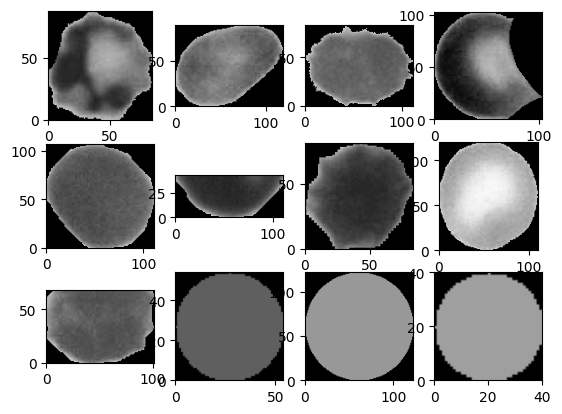

In [111]:
figure = plt.figure()
cols, rows = 4, 3
for i in range(cols * rows):
    sample_idx = i
    img = my_cells[sample_idx]
    figure.add_subplot(rows, cols, i+1)
    plt.imshow(img,cmap='gray',vmin=0,vmax=255,extent=(0, img.shape[1], 0, img.shape[0]))
plt.show()

In [133]:
class BackDataset(Dataset):
    def __init__(self, path_to_backs, back_size, patch_size):
        self.path = path_to_backs
        self.ps = patch_size
        self.bs = back_size
        self.patches = []
        self.data = []
        self.k = (np.array(back_size)/np.array(patch_size)).astype(np.uint8)

    def add_patch_from_img(self, num_back, num):
        self.back_names = random.choices(os.listdir(self.path),k=num_back)
        for i in range(num):
            name = random.choice(self.back_names)
            img = cv2.imread(self.path + '/' + name, cv2.IMREAD_GRAYSCALE)
            y0 = random.randint(0,img.shape[0]-self.ps[0])
            x0 = random.randint(0,img.shape[1]-self.ps[1])
            patch = img[y0:y0+self.ps[0], x0:x0+self.ps[1]]
            self.patches.append(patch)

    def add_patch_rect(self, num, min_color, max_color):
        for i in range(num):
            color = random.randint(min_color, max_color)
            img = np.ones(self.ps)*color
            self.patches.append(img.astype(np.uint8))

    def create_background(self, num):
        for i in range(num):
            img = np.zeros(self.bs).astype(np.uint8)

            img[self.bs[0]-self.ps[0]:,self.bs[1]-self.ps[1]:] = random.choice(self.patches)          
            
            for n in range(self.k[0]):
                y0 = n*self.ps[0]
                x0 = self.bs[1]-self.ps[1]
                img[y0:y0+self.ps[0], x0:] = random.choice(self.patches) 
                
            for m in range(self.k[1]):
                y0 = self.bs[0]-self.ps[0]
                x0 = m*self.ps[1]
                img[y0:, x0:x0+self.ps[1]] = random.choice(self.patches)        
            
            for n in range(self.k[0]):
                for m in range(self.k[1]):
                    y0 = n*self.ps[0]
                    x0 = m*self.ps[1]
                    img[y0:y0 + self.ps[0], x0:x0 + self.ps[1]] = random.choice(self.patches)

            self.data.append(img)
                                

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        return self.data[idx]

In [134]:
my_back = BackDataset('BCCD/background_full', [1050,1280],[100,100])

In [135]:
my_back.add_patch_from_img(3,9)
my_back.add_patch_rect(3,150,220)

In [136]:
my_back.create_background(3)

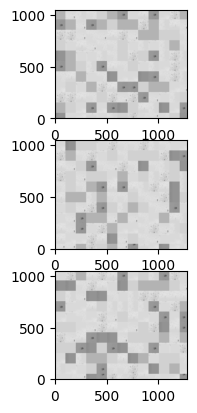

In [137]:
figure = plt.figure()
cols, rows = 1, 3
for i in range(cols * rows):
    sample_idx = i
    img = my_back[sample_idx]
    figure.add_subplot(rows, cols, i+1)
    plt.imshow(img,cmap='gray',vmin=0,vmax=255,extent=(0, img.shape[1], 0, img.shape[0]))
plt.show()

In [320]:
class CellsOnBackgroundDataset(Dataset):
    def __init__(
        self,
        dataset_size: int,
        cells_dataset: Dataset,
        back_dataset: Dataset,
    ):
        self.dataset_size = dataset_size
        self.cell_images = cells_dataset
        self.back_images = back_dataset
        self.data = []
        self.labels = []

    def create_data(self, min_num, max_num):
        for _ in range(self.dataset_size):
            num = random.randint(min_num, max_num)
            img = random.choice(self.back_images)
            img = np.stack((img, img, img), axis=2)
            
            for i in range(num):
                cell_img = random.choice(self.cell_images)
                cell_img = np.stack((cell_img, cell_img, cell_img), axis=2)
                mask = np.ones(cell_img.shape, dtype=np.uint8)*255
            
                top, bottom, left, right = 150, 150, 150, 150
                border_back = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
                border_cell = cv2.copyMakeBorder(cell_img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
                border_mask = cv2.copyMakeBorder(mask, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

                y0 = random.randint(border_cell.shape[0], border_back.shape[0] - border_cell.shape[0])
                x0 = random.randint(border_cell.shape[1], border_back.shape[1] - border_cell.shape[1])
                  
                out = cv2.seamlessClone(border_cell, border_back, border_mask, [y0,x0], cv2.NORMAL_CLONE)
                img = out[top:-bottom,left:-right,:]
            self.data.append(img[:,:,0])        


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
    

In [321]:
my_data = CellsOnBackgroundDataset(6, my_cells, my_back)

In [322]:
my_data.create_data(10,30)

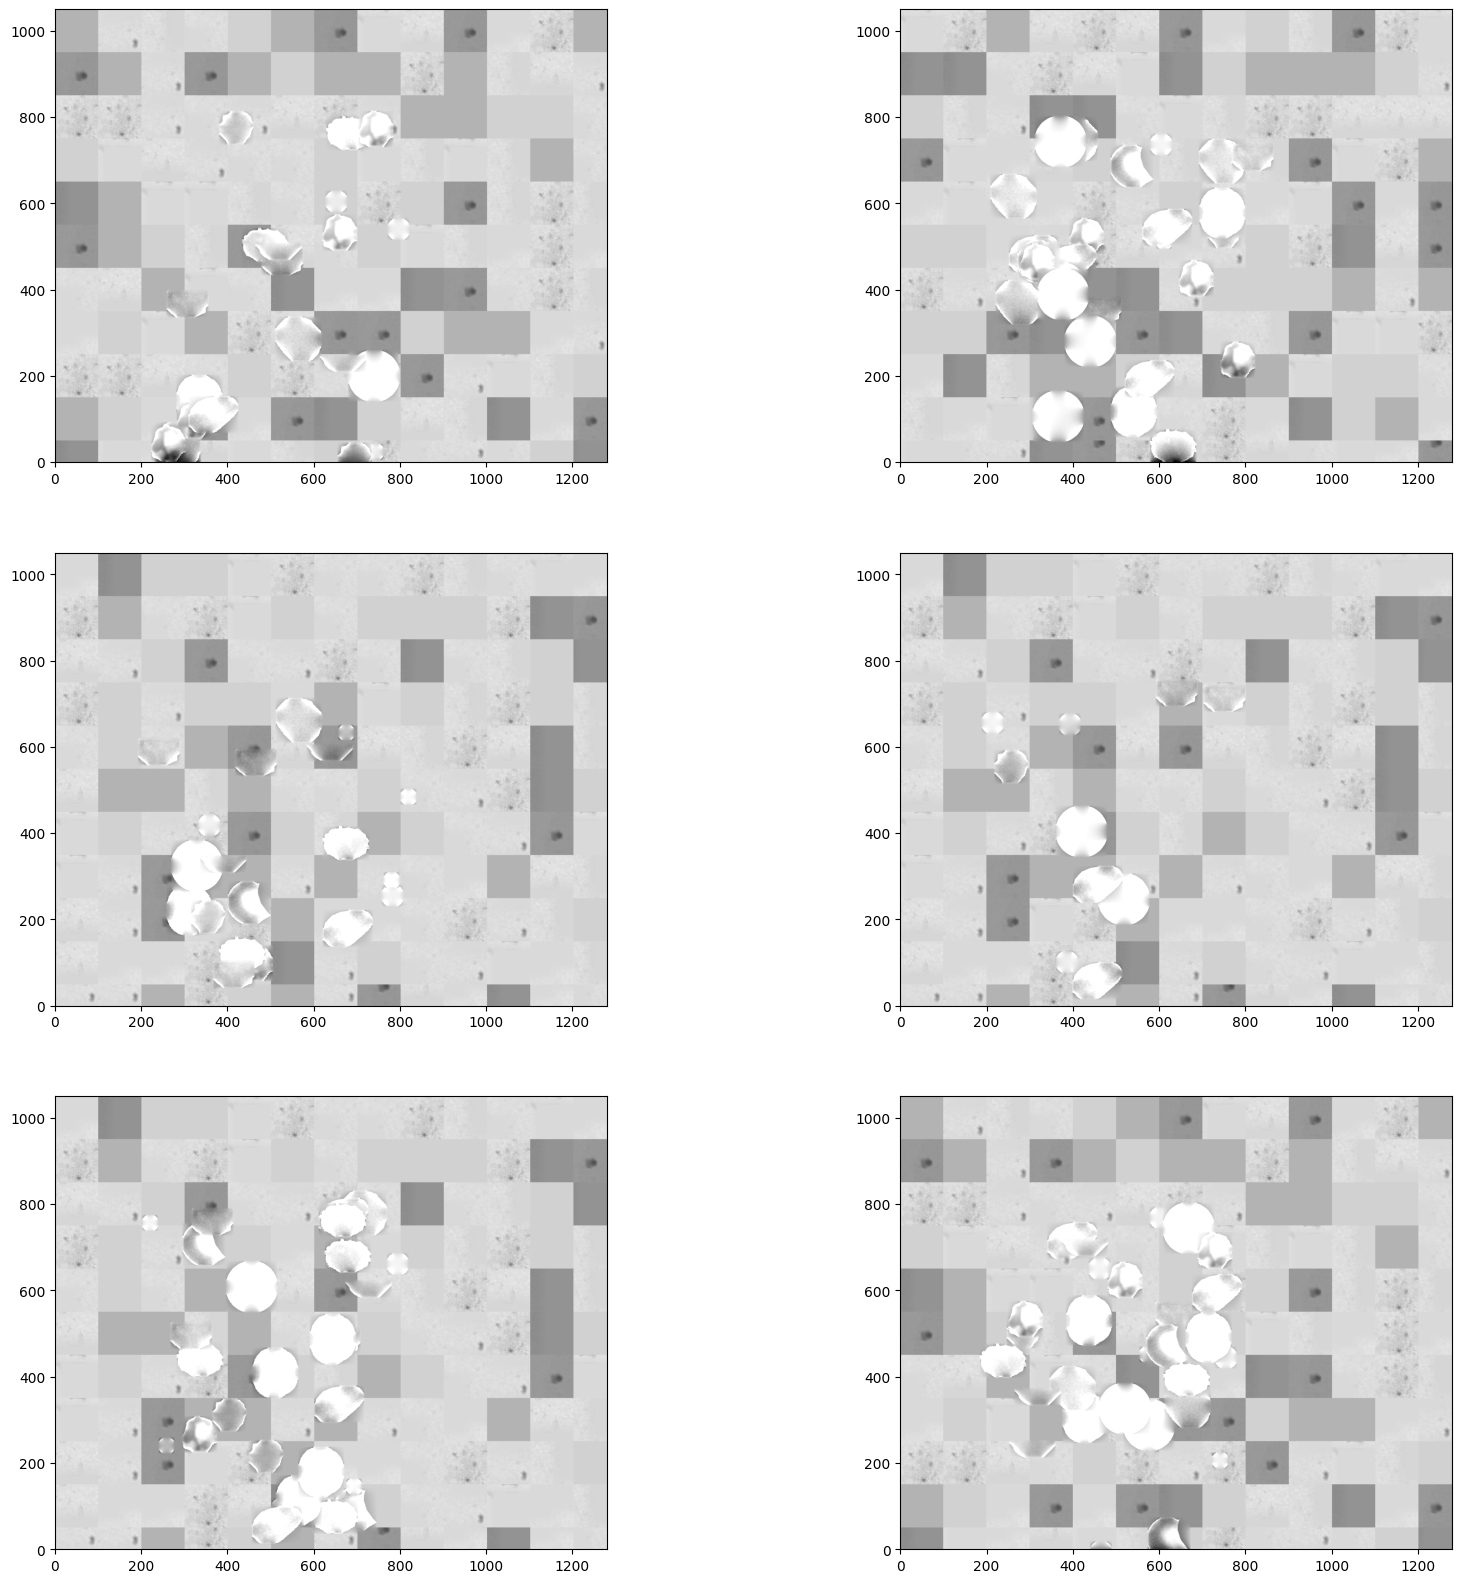

In [325]:
figure = plt.figure(figsize=(20,20))
cols, rows = 2, 3
for i in range(cols * rows):
    sample_idx = i
    img = my_data[sample_idx]
    figure.add_subplot(rows, cols, i+1)
    plt.imshow(img,cmap='gray',vmin=0,vmax=255,extent=(0, img.shape[1], 0, img.shape[0]))
plt.show()